# This script present the p2p cGAN model for segmenting plant in hyperspectral images

# Import the libraries (if you do not have any library do pip install xxx)

# Load data and divided the imaged scece into training and test set

In [1]:
!pip install tensorflow

In [3]:
from sklearn.feature_extraction import image
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Activation, Dropout, UpSampling2D, Concatenate, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot

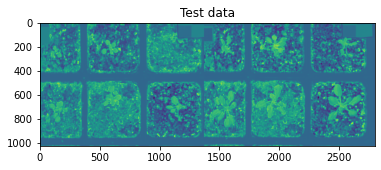

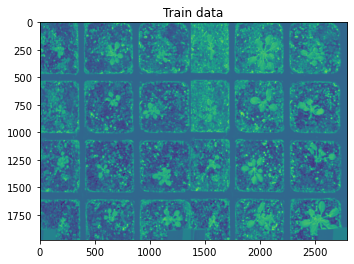

In [4]:
temp = sio.loadmat('leaf_data_pca_tranformed.mat')  #loading image
data = temp['image_vsn'] #load the already PCA transformed image
del temp
test_data = data[:1024,:,:]    # defined independent test data 12 plants
train_data = data[1024:,:,:]   # define training and validation data 24 plants

plt.imshow(test_data[:,:,1])
plt.title('Test data')
plt.show()

plt.imshow(train_data[:,:,1])
plt.title('Train data')
plt.show()

# subsample the hyperspectral images and extract 515*512 size patches

In [5]:
# extract patches from train set for training and validation (500 patches extracted)
patch_size = (512, 512)
data_temp = image.extract_patches_2d(train_data, patch_size, max_patches=500)

In [6]:
# filter patches and keep only patched which have both plant and backgroun and remove patches with have either only plant or only background
mask = data_temp[:,:,:,4]
to_keep = []
for i in range(500):
    temp_mask = mask[i,:]
    s = len(np.unique(temp_mask))
    if s==2:
        to_keep.append(i)

In [7]:
data_1 = data_temp[to_keep,:,:,:] #keeping useful ptaches with both plant and backgroun in scence
X_train = data_1[:,:,:,0:4]  # keep the spectral image
Y_train = data_1[:,:,:,4:6]   # keep the groun truth segmentation mask
del data_1 
del data_temp
del train_data

In [8]:
# print the shape of total number of samples for training and validation
print('X_train shape : ' + str(X_train.shape))
print('Y_train shape : ' + str(Y_train.shape))

X_train shape : (500, 512, 512, 4)
Y_train shape : (500, 512, 512, 2)


In [9]:
src_images, tar_images = X_train,Y_train  # make the data in GAN model accpetable format as GAN will accept data in pair

In [10]:
print(len(X_train))
print(len(Y_train))

500
500


# Subsample also the test image into patchces for model indepedent test at the end

In [11]:
#extract 100 patches
patch_size = (512, 512)
data_temp = image.extract_patches_2d(test_data, patch_size, max_patches=1000)

In [12]:
#keep patches that have both plant and background
mask = data_temp[:,:,:,4]
to_keep = []
for i in range(1000):
    temp_mask = mask[i,:]
    s = len(np.unique(temp_mask))
    if s==2:
        to_keep.append(i)

In [13]:
data_1 = data_temp[to_keep,:,:,:] #keeping useful ptaches with both plant and backgroun in scence
X_test = data_1[:,:,:,0:4]  # keep the spectral image
Y_test = data_1[:,:,:,4:6] # keep the groun truth segmentation mask
del data_1 
del data_temp
del test_data

# by this point you have loaded the dataset and prepared it for model training and independent test

# Now we define the p2p GAN model

In [16]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=(512,512,2))
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d=  BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    #--> lr-->0.001  beta-->0.9
    opt = Adam(lr=0.001, beta_1=0.9)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    #--> alpha
    g = LeakyReLU(alpha=0.3)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(512,512,2)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(2, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    #sigmoid --> tanh
    out_image = Activation('sigmoid')(g)
    # define model
    model = Model(in_image, out_image)
    return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i,:,:,0])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i,:,:,0])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i,:,:,0])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))
    
losss_appender = []

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    train_len = trainA / 10
    bat_per_epo = int(train_len*n_batch)
    #int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        losss_appender.append([d_loss1, d_loss2, g_loss])
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)


# Time for model training to start

In [ ]:
dataset = src_images, tar_images
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (500, 512, 512, 4) (500, 512, 512, 2)


C:\Users\acer\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, d1[0.428] d2[113.906] g[49.609]
>2, d1[0.001] d2[33.710] g[81.187]
>3, d1[16.333] d2[0.787] g[79.109]
>4, d1[16.333] d2[4.261] g[55.015]
>5, d1[5.023] d2[11.782] g[46.339]
>6, d1[1.094] d2[16.020] g[45.166]
>7, d1[0.770] d2[10.725] g[45.846]
>8, d1[2.167] d2[2.542] g[53.695]
>9, d1[6.978] d2[0.506] g[53.250]
>10, d1[6.857] d2[0.417] g[40.582]
>11, d1[1.092] d2[4.522] g[38.072]
>12, d1[0.408] d2[4.428] g[37.638]
>13, d1[0.655] d2[0.316] g[43.438]
>14, d1[4.051] d2[0.035] g[35.994]
>15, d1[0.868] d2[3.134] g[33.316]
>16, d1[0.026] d2[1.754] g[37.162]
>17, d1[2.538] d2[0.027] g[36.882]
>18, d1[2.882] d2[0.983] g[30.385]
>19, d1[0.148] d2[2.185] g[31.244]
>20, d1[0.954] d2[0.789] g[30.019]
>21, d1[1.073] d2[1.395] g[28.310]
>22, d1[0.646] d2[0.797] g[29.516]
>23, d1[1.726] d2[0.476] g[27.255]
>24, d1[1.056] d2[1.600] g[24.617]
>25, d1[0.421] d2[1.183] g[26.093]
>26, d1[1.485] d2[0.295] g[24.266]
>27, d1[1.043] d2[1.485] g[21.223]
>28, d1[0.147] d2[0.778] g[23.465]
>29, d1[1.676] d2[0.0

In [ ]:
x=np.mean(losss_appender)
print(x)
y=np.std(losss_appender)
print(y)

# PLot model training 

In [ ]:
ks = np.array(losss_appender)
plt.figure(figsize = (16,6))
plt.plot(ks[:,0], label = 'Discriminator for real samples')
plt.plot(ks[:,1], label = 'Discriminator for synthesized samples')
plt.plot(ks[:,2], label = 'Generator model')
plt.xlabel('Runs')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.savefig('Gan.tiff',dpi=150,format='tiff')

plt.show()

# Synthesize some segmentation mask for test set and plot them side by side

In [ ]:
dataset2 = X_test, Y_test
[X_realA, X_realB], _ = generate_real_samples(dataset2, 5, 1)
X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(X_realA[0,:,:,1])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(X_realB[0,:,:,1])
plt.axis('off')
plt.subplot(1,3,3)

plt.imshow(np.argmax(X_fakeB[0,:,:,:], axis=2))
plt.axis('off')
plt.savefig('gan_pred.tiff',dpi=150, format = 'tiff')
plt.show()

In [ ]:
dataset2 = X_test, Y_test
[X_realA, X_realB], _ = generate_real_samples(dataset2, 10, 1)
X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(X_realA[0,:,:,1])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(X_realB[0,:,:,1])
plt.axis('off')
plt.subplot(1,3,3)

plt.imshow(np.argmax(X_fakeB[0,:,:,:], axis=2))
plt.axis('off')
plt.savefig('gan_pred.tiff',dpi=150, format = 'tiff')
plt.show()

In [ ]:
dataset2 = X_test, Y_test
[X_realA, X_realB], _ = generate_real_samples(dataset2, 15, 1)
X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(X_realA[0,:,:,1])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(X_realB[0,:,:,1])
plt.axis('off')
plt.subplot(1,3,3)

plt.imshow(np.argmax(X_fakeB[0,:,:,:], axis=2))
plt.axis('off')
plt.savefig('gan_pred.tiff',dpi=150, format = 'tiff')
plt.show()

# Estimate mean IoU accuracy on 1000 test samples

In [1]:
[X_realA, X_realB], _ = generate_real_samples(dataset2,100, 1)
X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

NameError: name 'generate_real_samples' is not defined

In [35]:
import tensorflow.keras.backend as K
gan_acc = []
for i in range(1000):
    y_true_f = K.flatten(X_realB[i,:,:,1])
    y_pred_f = K.flatten(np.argmax(X_fakeB[i,:,:,:],axis=2))
    ksss = np.float32(y_true_f) * np.float32(y_pred_f)
    intersection = K.sum(ksss)
    smooth=1.
    tp = (intersection + smooth) / (K.sum(np.float32(y_true_f)) + K.sum(np.float32(y_pred_f)) - intersection + smooth)
    gan_acc.append(tp)          

ValueError: operands could not be broadcast together with shapes (1024,) (262144,) 

In [ ]:
# mean accuracy
np.mean(gan_acc)

In [ ]:
#std
np.std(gan_acc)